<a href="https://colab.research.google.com/github/Palak0905/CODECRAFT_GA_05/blob/main/Neural_Style_Transfer_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎨 Neural Style Transfer in PyTorch
Apply the artistic style of one image (e.g., a famous painting) to the content of another image using deep learning!

In [1]:

!pip install torch torchvision pillow matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import copy


In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512 if torch.cuda.is_available() else 256

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor()
])

def image_loader(image_path):
    image = Image.open(image_path)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


In [6]:

from google.colab import files
uploaded = files.upload()

# Replace these with the names of the uploaded files
content_img = image_loader("content_sample.jpg")
style_img = image_loader("style_sample.jpg")


Saving style_sample.jpg to style_sample.jpg


In [7]:

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.pause(0.001)


In [8]:

class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target.detach()
    def forward(self, x):
        self.loss = nn.functional.mse_loss(x, self.target)
        return x

def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super().__init__()
        self.target = gram_matrix(target_feature).detach()
    def forward(self, x):
        G = gram_matrix(x)
        self.loss = nn.functional.mse_loss(G, self.target)
        return x


In [9]:

cnn = models.vgg19(pretrained=True).features.to(device).eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)
    def forward(self, img):
        return (img - self.mean) / self.std


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 97.9MB/s]


In [10]:

def get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_layers = ['conv_4']
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            continue

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target = model(style_img).detach()
            style_loss = StyleLoss(target)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i + 1)]

    return model, style_losses, content_losses


In [11]:

input_img = content_img.clone()

def run_style_transfer(cnn, norm_mean, norm_std, content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    model, style_losses, content_losses = get_style_model_and_losses(cnn, norm_mean, norm_std, style_img, content_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print('Optimizing...')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)

            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            loss = style_score * style_weight + content_score * content_weight
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"Step {run[0]}: Style Loss: {style_score.item():.4f} Content Loss: {content_score.item():.4f}")

            return loss

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    return input_img


Optimizing...
Step 50: Style Loss: 0.0007 Content Loss: 10.4873
Step 100: Style Loss: 0.0005 Content Loss: 10.9348
Step 150: Style Loss: 0.0004 Content Loss: 10.8601
Step 200: Style Loss: 0.0004 Content Loss: 10.8169
Step 250: Style Loss: 0.0004 Content Loss: 10.9975
Step 300: Style Loss: 0.0002 Content Loss: 11.6588


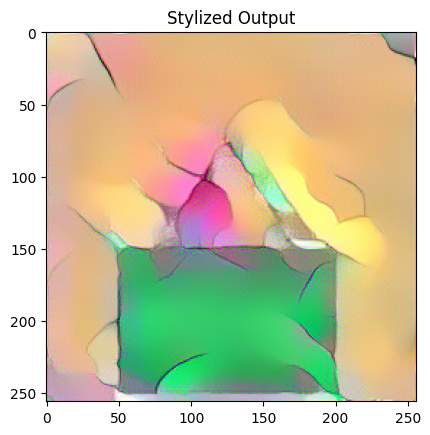

In [12]:

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Stylized Output')
plt.ioff()
plt.show()
